<a href="https://colab.research.google.com/github/sagarrokad1/Speech-Emotion-Recognition/blob/main/Notebooks/2_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing Libraries**

In [ ]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
from tqdm import tqdm

import os, glob, sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

import soundfile as sf
import IPython.display as ipd
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#mounting the google drive to import the dataset

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
audio = "/content/drive/MyDrive/AlmaBetter/Capstone Projects/Speech Emotion Recognition - Sagar Rokad/Audio_data/"

####**Loading audio file**

In [ ]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstone Projects/Speech Emotion Recognition - Sagar Rokad/audio.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/content/drive/MyDrive/AlmaBetter/Capstone Pro...
1,male,neutral,1,/content/drive/MyDrive/AlmaBetter/Capstone Pro...
2,male,calm,1,/content/drive/MyDrive/AlmaBetter/Capstone Pro...
3,male,neutral,1,/content/drive/MyDrive/AlmaBetter/Capstone Pro...
4,male,calm,1,/content/drive/MyDrive/AlmaBetter/Capstone Pro...


In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [ ]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


# **Data Augmentation**

#### **Add Noise, Stretch, Speed and Pitch to Original Audio File**

Text(0.5, 1.0, 'Waveplot - Male happy')

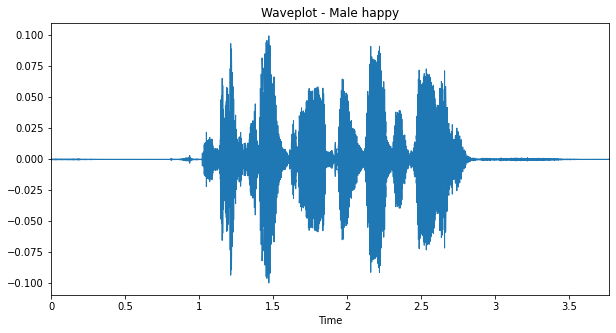

In [ ]:
# MALE Happy ORIGINAL AUDIO FILE
fname = audio + 'Actor_03/03-01-03-01-01-01-03.wav'  
X, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(X, sr=sr)
plt.title('Waveplot - Male happy')

In [ ]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

###**Noise**

Text(0.5, 1.0, 'Waveplot - Noise Male Happy')

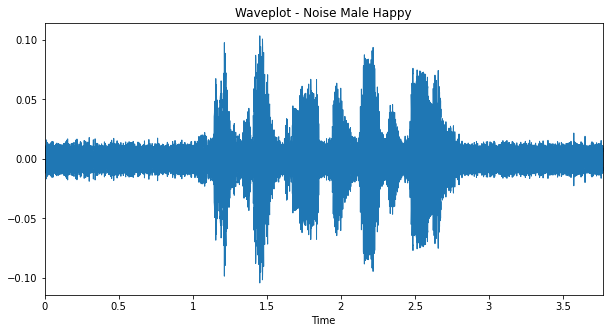

In [ ]:
# ADD NOISE TO MALE Happy ORIGINAL AUDIO FILE
x = noise(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Happy')

###**Stretch**

In [ ]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

Text(0.5, 1.0, 'Waveplot - Stretch Male Happy')

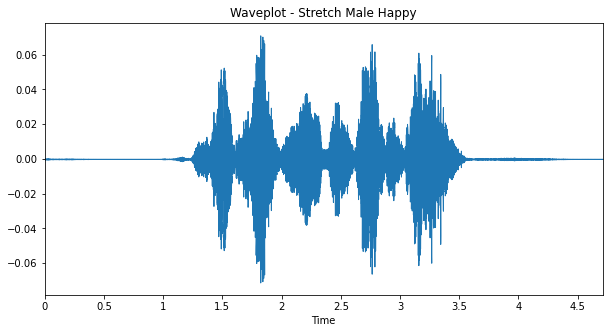

In [ ]:
# ADD STRETCH TO MALE Happy ORIGINAL AUDIO FILE
x = stretch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Happy')

###**Speed N Pitch**

In [ ]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

Text(0.5, 1.0, 'Waveplot - Speed and Pitch Male Happy')

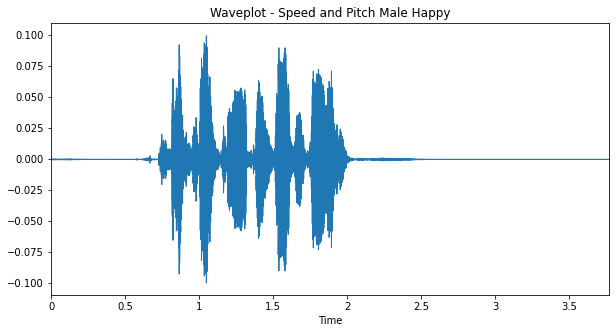

In [ ]:
# ADD SPEED AND PITCH TO MALE Happy ORIGINAL AUDIO FILE
x = speedNpitch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Happy')

**The above shown all distints waveplots have been created after adding Noise, Stretch, Speed and Pitch to Original Audio File.**

####**Apply Data Augmentation Methods to Train Set**

In [ ]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-56.86472, -56.86472, -56.86472, -56.86472, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-56.91174, -57.247, -58.062386, -57.80188, -5..."
3,"[-68.403206, -68.403206, -68.403206, -68.40320..."
4,"[-70.05719, -69.4036, -68.90284, -68.67733, -6..."


In [ ]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-56.86472, -56.86472, -56.86472, -56.86472, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-56.91174, -57.247, -58.062386, -57.80188, -5..."
3,"[-68.403206, -68.403206, -68.403206, -68.40320..."
4,"[-70.05719, -69.4036, -68.90284, -68.67733, -6..."


In [ ]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-58.583622, -58.583622, -58.583622, -58.58362..."
1,"[-68.67724, -68.674675, -68.76416, -68.579094,..."
2,"[-59.57485, -59.564373, -59.284966, -58.72177,..."
3,"[-70.97209, -70.97209, -70.97209, -70.97209, -..."
4,"[-70.75394, -69.881584, -68.90107, -67.93323, ..."


In [ ]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-56.86472, -56.86472, -56.86472, -56.86472, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-56.91174, -57.247, -58.062386, -57.80188, -5..."
3,"[-68.403206, -68.403206, -68.403206, -68.40320..."
4,"[-70.05719, -69.4036, -68.90284, -68.67733, -6..."


###**Combine Tables For Modeling**

In [ ]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [ ]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [ ]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,emotion
4603,-55.350864,-54.635700,-54.561180,-55.446121,-55.953434,-56.111580,-56.143040,-56.143040,-56.092976,-56.070923,-55.837639,-55.461178,-55.180954,-54.755665,-54.635277,-54.614250,-53.847015,-53.324734,-52.871319,-53.313087,-53.552021,-52.871544,-52.775070,-53.566254,-53.544525,-53.539707,-53.628799,-53.863235,-53.895973,-54.010418,-54.609024,-55.256470,-55.954945,-55.915829,-54.567009,-53.281651,-54.843540,-55.983639,-56.038185,-55.888046,...,-52.065670,-52.912498,-54.112488,-54.965298,-55.177380,-55.051971,-55.015125,-55.390179,-55.677193,-55.826939,-55.737907,-55.863113,-55.864239,-55.914230,-55.863487,-55.762634,-55.820210,-55.763981,-55.911430,-56.054672,-55.780342,-55.605019,-55.884808,-55.968689,-56.066998,-56.063118,-55.853905,-55.986694,-56.132336,-55.959827,-55.757290,-55.860142,-55.975815,-55.939114,-56.025181,-55.984623,-56.052174,-56.140205,-56.143040,angry
4604,-79.819061,-79.843567,-79.170364,-79.945946,-81.547348,-82.300919,-82.016556,-81.573296,-80.775131,-81.826988,-82.331703,-81.453484,-81.693993,-82.485321,-82.630867,-82.630867,-82.630867,-82.630867,-82.630867,-82.419701,-81.164093,-81.191963,-82.454834,-82.481049,-81.787422,-81.895966,-82.579651,-82.627571,-82.599289,-82.383392,-81.543289,-80.847786,-81.371964,-80.038811,-80.407791,-79.085175,-75.843948,-73.542549,-72.044884,-70.414024,...,-77.283524,-77.306969,-77.891045,-77.789955,-78.476562,-79.419533,-80.051941,-79.320236,-78.965111,-79.449844,-79.290375,-78.836685,-79.130455,-79.235184,-79.491425,-79.448006,-79.190666,-79.051590,-79.715668,-80.323761,-80.550087,-80.018044,-80.789406,-79.448738,-80.058235,-80.020851,-80.529449,-81.024475,-79.846672,-79.668777,-79.627632,-79.490807,-79.234741,-79.334358,-79.351967,-79.987419,-79.511841,-79.027077,-79.262009,sad
4605,-77.548431,-77.537270,-77.459946,-77.396561,-77.548431,-77.548431,-77.548431,-77.517204,-77.548431,-77.548431,-77.543350,-77.544189,-77.548431,-77.548431,-77.498711,-77.510506,-77.316544,-77.528435,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.547890,-76.502388,-73.644287,-70.970215,-69.680550,-69.137085,-69.826927,-71.017479,-71.531258,-68.745293,...,-77.548431,-77.374481,-77.445229,-77.548431,-77.548431,-77.548431,-77.513222,-77.548431,-77.548431,-77.544769,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.544228,-77.299576,-77.530128,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.468239,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,sad
4606,-72.728462,-70.554390,-70.852989,-74.814201,-76.173805,-74.715195,-74.492203,-74.674660,-75.293221,-75.495026,-76.126060,-77.787422,-79.018829,-79.625435,-80.510490,-78.753342,-77.402321,-77.748192,-78.067162,-79.634361,-80.843460,-79.715012,-80.151817,-80.069084,-78.478447,-78.387146,-79.409012,-80.679565,-80.594330,-79.542992,-76.704941,-76.701385,-77.224770,-77.723114,-76.324112,-77.112190,-76.506287,-74.179062,-72.390327,-73.033180,...,-79.078171,-79.169754,-79.403282,-79.740471,-79.774254,-80.429367,-80.862656,-81.344093,-80.777367,-80.036285,-80.977646,-81.483475,-81.445808,-81.129623,-81.132080,-80.561813,-80.328255,-80.731987,-79.713165,-79.248383,-79.834541,-79.862099,-80.382179,-79.840302,-79.719727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4607,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.

**The new Dataframe after implementing data augmentation technique and extracting distinct features by using Mel spectrogram.**

In [ ]:
mfcc.shape,noise.shape,speedpitch.shape,stretch.shape

((1152, 260), (1152, 260), (1152, 260), (1152, 260))

In [ ]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

###**Feature Extraction for Test Set**

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-52.76322, -52.76322, -52.76322, -52.76322, -..."
1,"[-50.77538, -49.714672, -50.06737, -50.747746,..."
2,"[-61.993557, -61.993557, -61.993557, -61.99355..."
3,"[-52.010284, -52.010284, -52.010284, -52.01028..."
4,"[-65.7279, -65.7279, -65.7279, -65.7279, -65.7..."


In [ ]:
test.reset_index(drop=True,inplace=True)

In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/content/drive/MyDrive/AlmaBetter/Capstone Pro...,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.370380,-48.526329,-46.132549,-46.496235,-43.014095,-39.407925,-36.384762,-33.940887,-32.375683,-31.924116,-30.061274,-28.563995,-27.221067,-26.194651,-25.706356,-25.741217,-25.398100,-25.468767,-25.263351,-25.120495,-25.066256,-24.764282,-24.523005,...,-52.471634,-52.560459,-52.667191,-52.507000,-52.633717,-52.622929,-52.666950,-52.726643,-52.694691,-52.699741,-52.717453,-52.716175,-52.763222,-52.763222,-52.734112,-52.324459,-50.826057,-48.627930,-45.780178,-44.213753,-42.764778,-42.169403,-41.972843,-42.109455,-42.809196,-42.114136,-41.616962,-41.727291,-42.094898,-43.239326,-44.213104,-44.874271,-44.891907,-45.049019,-45.912987,-46.570332,-47.174248,-47.970875,-48.438820,-49.576263
1,male,calm,21,/content/drive/MyDrive/AlmaBetter/Capstone Pro...,-50.775379,-49.714672,-50.067371,-50.747746,-51.102058,-50.551704,-49.890587,-50.189316,-51.183151,-51.432728,-50.960247,-50.852249,-51.528526,-52.372524,-52.054935,-52.101425,-53.047592,-53.685131,-54.998924,-56.290028,-57.256359,-59.216606,-61.265549,-62.974960,-64.741531,-64.531769,-66.458260,-66.707443,-65.827347,-66.862946,-66.064842,-68.030655,-65.230209,-44.606339,-39.275139,-40.601315,...,-49.264008,-52.364399,-52.951710,-52.748692,-52.013687,-50.852478,-50.797020,-49.483841,-47.372814,-47.119270,-47.522282,-47.621708,-48.029068,-48.351238,-48.737106,-49.389366,-50.033382,-49.944809,-50.425762,-51.679531,-51.533035,-51.698353,-52.732250,-53.621185,-53.819645,-53.832935,-54.627689,-55.246548,-56.285191,-57.662468,-58.463360,-60.517998,-62.483250,-63.914776,-64.706757,-66.529182,-66.100319,-65.217224,-66.068062,-68.257401
2,female,happy,16,/content/drive/MyDrive/AlmaBetter/Capstone Pro...,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.641293,-61.501862,-61.820187,-61.989410,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,...,-60.808609,-60.692341,-61.317478,-61.681873,-61.554932,-61.714722,-61.575684,-61.320957,-61.512615,-61.830681,-61.779625,-61.662956,-61.655701,-61.783585,-61.499691,-61.290306,-61.576321,-61.750538,-61.832027,-61.467564,-61.556255,-61.979378,-61.993557,-61.993557,-61.984428,-61.883560,-61.730930,-61.834316,-61.983467,-61.982544,-61.972282,-61.989388,-61.993557,-61.825466,-61.676247,-61.871986,-61.980305,-61.993557,-61.993557,-61.939655
3,female,angry,12,/content/drive/MyDrive/AlmaBetter/Capstone Pro...,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-51.947044,-51.986725,...,-51.126438,-51.414608,-51.227760,-50.879223,-50.853416,-51.003571,-51.243141,-51.103477,-51.226387,-51.336636,-50.987186,-51.089462,-50.841438,-50.791992,-51.036854,-51.074055,-51.143967,-50.985062,-50.455872,-50.510483,-50.684872,-50.825176,-50.653584,-50.659107,-51.007633,-50.782154,-50.806499,-51.237865,-51.293766,-51.526310,-51.349499,-51.028931,-51.109413,-51.248970,-51.160564,-50.875484,-50.688412,-50.932213,-51.136345,-51.237747
4,male,fear,23,/content/drive/MyDrive/AlmaBetter/Capstone Pro...,-65.727898,-65.7278

In [ ]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [ ]:
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.370380,-48.526329,-46.132549,-46.496235,-43.014095,-39.407925,-36.384762,-33.940887,-32.375683,-31.924116,-30.061274,-28.563995,-27.221067,-26.194651,-25.706356,-25.741217,-25.398100,-25.468767,-25.263351,-25.120495,-25.066256,-24.764282,-24.523005,-25.462490,...,-52.471634,-52.560459,-52.667191,-52.507000,-52.633717,-52.622929,-52.666950,-52.726643,-52.694691,-52.699741,-52.717453,-52.716175,-52.763222,-52.763222,-52.734112,-52.324459,-50.826057,-48.627930,-45.780178,-44.213753,-42.764778,-42.169403,-41.972843,-42.109455,-42.809196,-42.114136,-41.616962,-41.727291,-42.094898,-43.239326,-44.213104,-44.874271,-44.891907,-45.049019,-45.912987,-46.570332,-47.174248,-47.970875,-48.438820,-49.576263
1,male,calm,21,-50.775379,-49.714672,-50.067371,-50.747746,-51.102058,-50.551704,-49.890587,-50.189316,-51.183151,-51.432728,-50.960247,-50.852249,-51.528526,-52.372524,-52.054935,-52.101425,-53.047592,-53.685131,-54.998924,-56.290028,-57.256359,-59.216606,-61.265549,-62.974960,-64.741531,-64.531769,-66.458260,-66.707443,-65.827347,-66.862946,-66.064842,-68.030655,-65.230209,-44.606339,-39.275139,-40.601315,-40.855137,...,-49.264008,-52.364399,-52.951710,-52.748692,-52.013687,-50.852478,-50.797020,-49.483841,-47.372814,-47.119270,-47.522282,-47.621708,-48.029068,-48.351238,-48.737106,-49.389366,-50.033382,-49.944809,-50.425762,-51.679531,-51.533035,-51.698353,-52.732250,-53.621185,-53.819645,-53.832935,-54.627689,-55.246548,-56.285191,-57.662468,-58.463360,-60.517998,-62.483250,-63.914776,-64.706757,-66.529182,-66.100319,-65.217224,-66.068062,-68.257401
2,female,happy,16,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.641293,-61.501862,-61.820187,-61.989410,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,-61.993557,...,-60.808609,-60.692341,-61.317478,-61.681873,-61.554932,-61.714722,-61.575684,-61.320957,-61.512615,-61.830681,-61.779625,-61.662956,-61.655701,-61.783585,-61.499691,-61.290306,-61.576321,-61.750538,-61.832027,-61.467564,-61.556255,-61.979378,-61.993557,-61.993557,-61.984428,-61.883560,-61.730930,-61.834316,-61.983467,-61.982544,-61.972282,-61.989388,-61.993557,-61.825466,-61.676247,-61.871986,-61.980305,-61.993557,-61.993557,-61.939655
3,female,angry,12,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-52.010284,-51.947044,-51.986725,-52.008987,...,-51.126438,-51.414608,-51.227760,-50.879223,-50.853416,-51.003571,-51.243141,-51.103477,-51.226387,-51.336636,-50.987186,-51.089462,-50.841438,-50.791992,-51.036854,-51.074055,-51.143967,-50.985062,-50.455872,-50.510483,-50.684872,-50.825176,-50.653584,-50.659107,-51.007633,-50.782154,-50.806499,-51.237865,-51.293766,-51.526310,-51.349499,-51.028931,-51.109413,-51.248970,-51.160564,-50.875484,-50.688412,-50.932213,-51.136345,-51.237747
4,male,fear,23,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727898,-65.727

In [ ]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

####**Data Preprocessing**

In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape,X_test.shape

((4608, 259, 1), (288, 259, 1))

# **Modelling**

###**CNN**

In [ ]:
# BUILD 1D CNN LAYERS
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 240, 64)           1344      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=80, validation_data=(X_test, y_test),callbacks=checkpoint)

Epoch 1/80
576/576 [==============================] - 34s 8ms/step - loss: 2.3248 - accuracy: 0.2795 - val_loss: 1.9804 - val_accuracy: 0.3125

Epoch 00001: val_loss improved from inf to 1.98037, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
Epoch 2/80
576/576 [==============================] - 5s 8ms/step - loss: 1.8777 - accuracy: 0.3518 - val_loss: 1.7298 - val_accuracy: 0.3819

Epoch 00002: val_loss improved from 1.98037 to 1.72982, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
Epoch 3/80
576/576 [==============================] - 4s 8ms/step - loss: 1.6949 - accuracy: 0.3867 - val_loss: 1.5995 - val_accuracy: 0.4201

Epoch 00003: val_loss improved from 1.72982 to 1.59946, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
Epoch 4/80
576/576 [==============================] - 4s 8ms/step - loss: 1.5795 - accuracy: 0.4227 - val_loss: 1.5231 - val

####**Model accuracy graph**

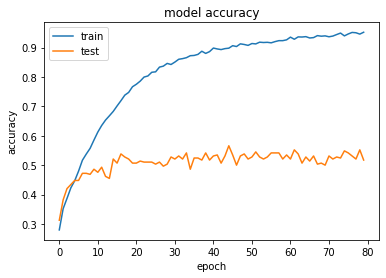

In [ ]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

####**Model loss graph**

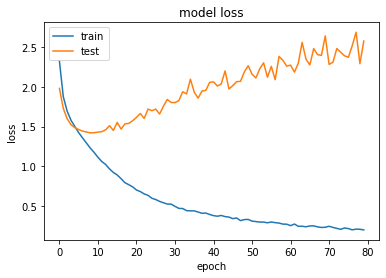

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

####**Actual vs Predicted**

In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,disgust
141,surprise,surprise
142,neutral,calm
143,sad,neutral
144,fear,surprise
145,sad,disgust
146,disgust,disgust
147,angry,surprise
148,surprise,disgust
149,angry,disgust


####**Confusion Matrix**

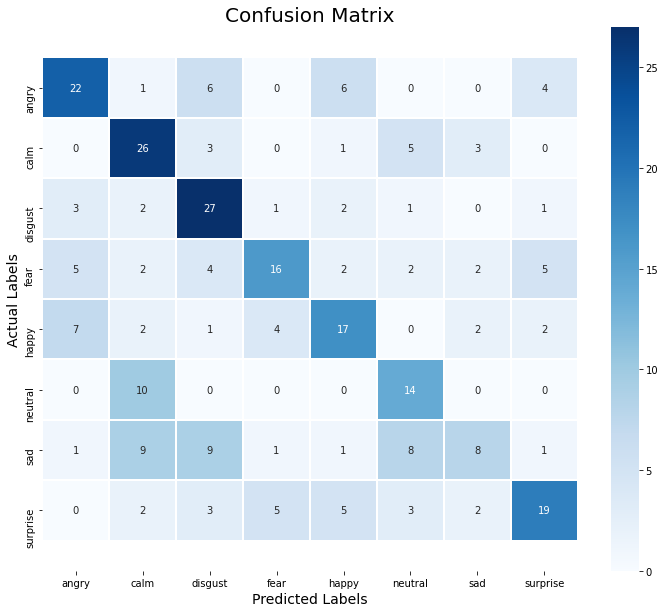

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.58      0.56      0.57        39
        calm       0.48      0.68      0.57        38
     disgust       0.51      0.73      0.60        37
        fear       0.59      0.42      0.49        38
       happy       0.50      0.49      0.49        35
     neutral       0.42      0.58      0.49        24
         sad       0.47      0.21      0.29        38
    surprise       0.59      0.49      0.54        39

    accuracy                           0.52       288
   macro avg       0.52      0.52      0.50       288
weighted avg       0.52      0.52      0.51       288



In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/AlmaBetter/Capstone Projects/Speech Emotion Recognition - Sagar Rokad/aug_model.hdf5')

In [ ]:
model.save_weights('/content/drive/MyDrive/AlmaBetter/Capstone Projects/Speech Emotion Recognition - Sagar Rokad/aug_weights.h5')